In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import missingno as msno

train = pd.read_csv('train.csv')

test = pd.read_csv('test.csv')

sample = pd.read_csv('sample_submission.csv')



display(train.describe().T, train.info(), train.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

,count,mean,std,min,25%,50%,75%,max
id,140700.0,70349.500000,40616.735775,0.00,35174.75,70349.50,105524.25,140699.0
Age,140700.0,40.388621,12.384099,18.00,29.00,42.00,51.00,60.0
Academic Pressure,27897.0,3.142273,1.380457,1.00,2.00,3.00,4.00,5.0
Work Pressure,112782.0,2.998998,1.405771,1.00,2.00,3.00,4.00,5.0
CGPA,27898.0,7.658636,1.464466,5.03,6.29,7.77,8.92,10.0
Study Satisfaction,27897.0,2.944940,1.360197,1.00,2.00,3.00,4.00,5.0
Job Satisfaction,112790.0,2.974404,1.416078,1.00,2.00,3.00,4.00,5.0
Work/Study Hours,140700.0,6.252679,3.853615,0.00,3.00,6.00,10.00,12.0
Financial Stress,140696.0,2.988983,1.413633,1.00,2.00,3.00,4.00,5.0
Depression,140700.0,0.181713,0.385609,0.00,0.00,0.00,0.00,1.0


None

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [2]:
train.isna().mean().round(4).sort_values(ascending=False)*100

Study Satisfaction                       80.17
Academic Pressure                        80.17
CGPA                                     80.17
Profession                               26.03
Work Pressure                            19.84
Job Satisfaction                         19.84
Dietary Habits                            0.00
Family History of Mental Illness          0.00
Financial Stress                          0.00
Work/Study Hours                          0.00
Have you ever had suicidal thoughts ?     0.00
Degree                                    0.00
id                                        0.00
Sleep Duration                            0.00
Name                                      0.00
Working Professional or Student           0.00
City                                      0.00
Age                                       0.00
Gender                                    0.00
Depression                                0.00
dtype: float64

<Axes: >

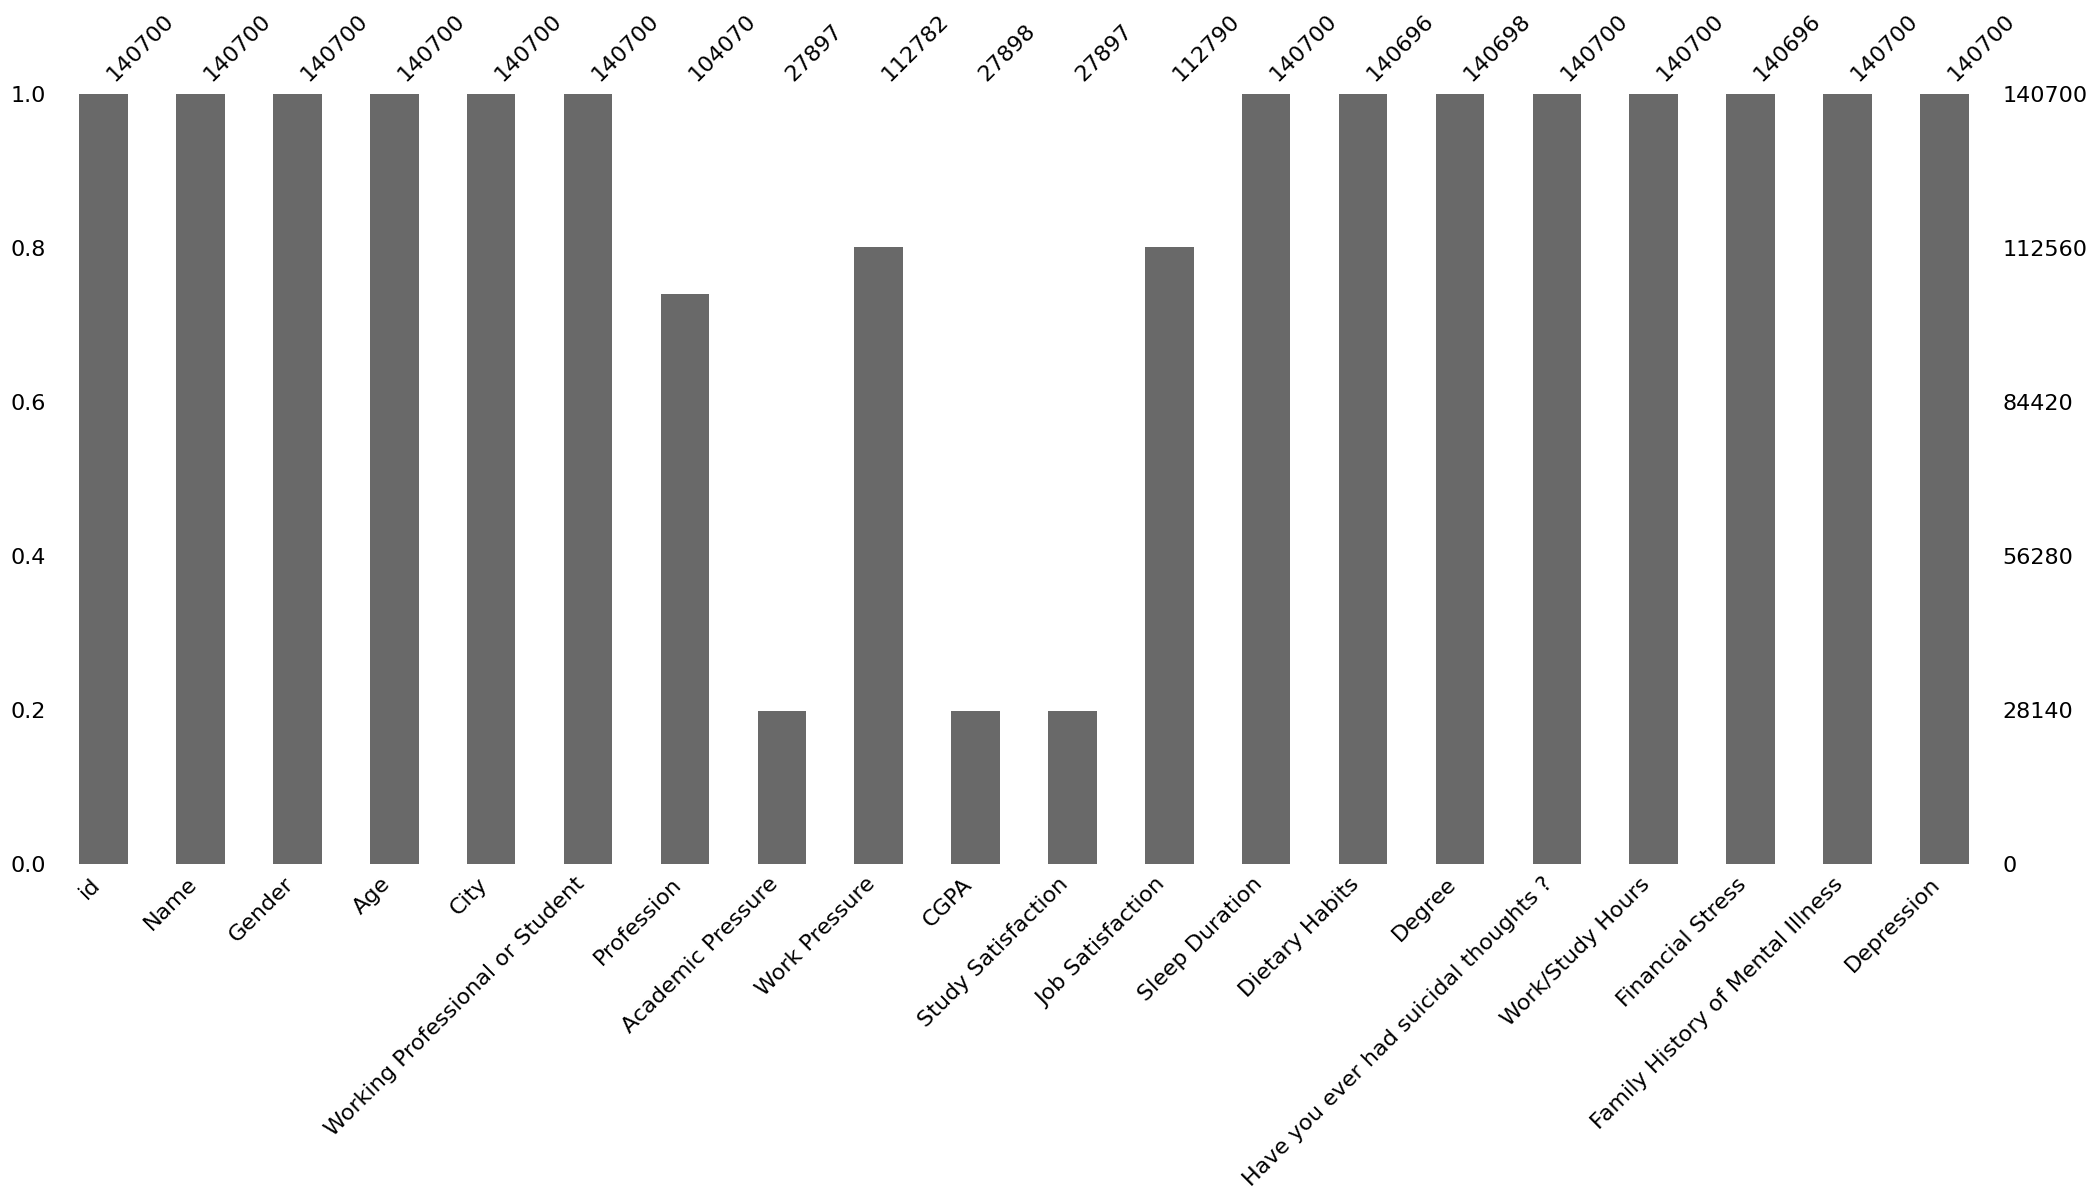

In [3]:
msno.bar(train)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
import catboost
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier

# Preprocessing function (same as before)
def preprocess_train(data):
    data = (
        data
        .assign(
            Profession=lambda df: df['Profession'].fillna(
                df['Working Professional or Student'].apply(
                    lambda x: 'Student' if x == 'Student' else 'Working Professional'
                )
            ),
            combinedPressure=lambda df: df.apply(
                lambda row: row['Academic Pressure'] if row['Working Professional or Student'] == 'Student'
                else row['Work Pressure'],
                axis=1
            ),
            satisfaction=lambda df: df.apply(
                lambda row: row['Study Satisfaction'] if row['Working Professional or Student'] == 'Student'
                else row['Job Satisfaction'],
                axis=1
            )
        )
        .drop(['Academic Pressure',
            'Work Pressure',
            'CGPA',
            'Study Satisfaction',
            'Job Satisfaction',
            'Name',
            'id'], axis=1)
        .dropna()  # Drop any rows with missing values
        .astype({
            "Gender": "category",
            "City": "category",
            "Working Professional or Student": "category",
            "Profession": "category",
            "Sleep Duration": "category",
            "Dietary Habits": "category",
            "Degree": "category",
            "Have you ever had suicidal thoughts ?": "category",
            "Family History of Mental Illness": "category",
            "Financial Stress": "category",
            # "Depression": "category",
            "combinedPressure": "float32",  # Assuming combinedPressure is numeric
            "satisfaction": "float32",  # Assuming satisfaction is numeric
            "Age": "float32",
            "Work/Study Hours": "float32"
        })
    )
    return data


def preprocess_test(data):
    data = (
        data
        .assign(
            Profession=lambda df: df['Profession'].fillna(
                df['Working Professional or Student'].apply(
                    lambda x: 'Student' if x == 'Student' else 'Working Professional'
                )
            ),
            combinedPressure=lambda df: df.apply(
                lambda row: row['Academic Pressure'] if row['Working Professional or Student'] == 'Student'
                else row['Work Pressure'],
                axis=1
            ),
            satisfaction=lambda df: df.apply(
                lambda row: row['Study Satisfaction'] if row['Working Professional or Student'] == 'Student'
                else row['Job Satisfaction'],
                axis=1
            )
        )
        .drop(['Academic Pressure',
            'Work Pressure',
            'CGPA',
            'Study Satisfaction',
            'Job Satisfaction',
            'Name',
            'id'], axis=1)
        .astype({
            "Gender": "category",
            "City": "category",
            "Working Professional or Student": "category",
            "Profession": "category",
            "Sleep Duration": "category",
            "Dietary Habits": "category",
            "Degree": "category",
            "Have you ever had suicidal thoughts ?": "category",
            "Family History of Mental Illness": "category",
            "Financial Stress": "category",
            "combinedPressure": "float32",
            "satisfaction": "float32",
            "Age": "float32",
            "Work/Study Hours": "float32"
        })
        # .apply(lambda col: col.fillna(col.mode()[0]) if col.isnull().any() else col)
    )

    return data



# Encode categorical columns
def encode_categorical(data, categorical_columns):
    label_encoder = LabelEncoder()
    for col in categorical_columns:
        data[col] = label_encoder.fit_transform(data[col])
    return data


train = preprocess_train(train)
test = preprocess_test(test)

# Define the categorical columns
categorical_columns = ['Gender', 'City', 'Working Professional or Student', 'Profession', 
                       'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
                       'Financial Stress', 'Family History of Mental Illness']

# Separate features (X) and target (y)
X = train.drop('Depression', axis=1)
y = train['Depression']

# Split the train dataset into train and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of X_train and y_train after splitting
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")



# Check that the shapes still match
assert X_train.shape[0] == y_train.shape[0], "X_train and y_train do not have the same number of rows!"
assert X_val.shape[0] == y_val.shape[0], "X_val and y_val do not have the same number of rows!"

# Encode categorical columns (Label Encoding)
X_train = encode_categorical(X_train, categorical_columns)
X_val = encode_categorical(X_val, categorical_columns)


test = encode_categorical(test, categorical_columns)

# Check that the test set has the correct number of rows
print(f"test shape: {test.shape}")

# 1. XGBoost Model with Hyperparameter Optimization
xgb_model = xgb.XGBClassifier()

# Define parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Use GridSearchCV to tune the XGBoost model
xgb_grid_search = GridSearchCV(xgb_model, xgb_param_grid, cv=3, n_jobs=-1, verbose=2)
xgb_grid_search.fit(X_train, y_train)

# Best hyperparameters for XGBoost
print(f"Best XGBoost parameters: {xgb_grid_search.best_params_}")

# Train the best model
xgb_model = xgb_grid_search.best_estimator_

# 2. CatBoost Model with Hyperparameter Optimization
catboost_model = CatBoostClassifier(cat_features=categorical_columns, iterations=1000, learning_rate=0.1, depth=6)

# Define parameter grid for CatBoost
catboost_param_grid = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [3, 5, 7]
}

# Use GridSearchCV to tune the CatBoost model
catboost_grid_search = GridSearchCV(catboost_model, catboost_param_grid, cv=3, n_jobs=-1, verbose=2)
catboost_grid_search.fit(X_train, y_train)

# Best hyperparameters for CatBoost
print(f"Best CatBoost parameters: {catboost_grid_search.best_params_}")

# Train the best model
catboost_model = catboost_grid_search.best_estimator_

# 3. LightGBM Model with Hyperparameter Optimization
lgbm_model = lgb.LGBMClassifier()

# Define parameter grid for LightGBM
lgbm_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 70],
    'max_depth': [-1, 5, 10],
    'subsample': [0.8, 0.9, 1.0]
}

# Use GridSearchCV to tune the LightGBM model
lgbm_grid_search = GridSearchCV(lgbm_model, lgbm_param_grid, cv=3, n_jobs=-1, verbose=2)
lgbm_grid_search.fit(X_train, y_train)

# Best hyperparameters for LightGBM
print(f"Best LightGBM parameters: {lgbm_grid_search.best_params_}")

# Train the best model
lgbm_model = lgbm_grid_search.best_estimator_

# 4. Random Forest Model with Hyperparameter Optimization
rf_model = RandomForestClassifier()

# Define parameter grid for RandomForest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Use GridSearchCV to tune the RandomForest model
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=3, n_jobs=-1, verbose=2)
rf_grid_search.fit(X_train, y_train)

# Best hyperparameters for RandomForest
print(f"Best RandomForest parameters: {rf_grid_search.best_params_}")

# Train the best model
rf_model = rf_grid_search.best_estimator_

# 5. Create a Voting Classifier with the optimized models
voting_clf = VotingClassifier(estimators=[('xgb', xgb_model), ('catboost', catboost_model),
                                          ('lgbm', lgbm_model), ('rf', rf_model)], voting='hard')

# Train the Voting Classifier on the training set
voting_clf.fit(X_train, y_train)

# Evaluate the model on the validation set
val_accuracy = voting_clf.score(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy}")

# Once the model is validated, evaluate on the test set
y_pred_test = voting_clf.predict(test)


X_train shape: (112522, 14), y_train shape: (112522,)
X_val shape: (28131, 14), y_val shape: (28131,)
test shape: (93800, 14)
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best XGBoost parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.9}
Fitting 3 folds for each of 81 candidates, totalling 243 fits


In [ ]:
pd.read_csv('test.csv')

In [ ]:
pd.re

In [ ]:
test = pd.read_csv('test.csv')

In [ ]:
# Create the submission DataFrame
submission = pd.DataFrame({
    'id': test.id,  # Use the index of test set as 'id'
    'Depression': y_pred_test
})

# Save the submission file
submission.to_csv('submissionv2.csv', index=False)

print("Test predictions have been saved to 'submission.csv'")